In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
from pykalman import KalmanFilter
from getdata import GetDataset
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:
data_orig,target = GetDataset(CreateDataFrame=True).Outputdata()

In [3]:
#Interpolacion para que los datos en x1 sean x distantes
x_data = np.linspace(data_orig[0][0].min(),data_orig[0][0].max(),901)
temp = np.zeros((data_orig.shape[0],901))
for i in range(data_orig.shape[0]):
    temp[i,:] = np.interp(x_data,data_orig[i][0][:],data_orig[i][1][:])

In [4]:
# Creacion de arreglos matriciales 30x30 2 channels
data = np.zeros((temp.shape[0],temp.shape[1],2))
for i in range(data.shape[0]):
    data[i,:,0] = savgol_filter(temp[i,:], window_length=50, polyorder=2)
    data[i,:,1] = np.gradient(savgol_filter(data[i,:,0], window_length=50, polyorder=2))

In [5]:
torch.manual_seed(42)
shuffle_idx = torch.randperm(3090, dtype = torch.long)
data_shuffle = data[shuffle_idx]
target_shuffle = target[shuffle_idx]
shuffle_idx

tensor([2082, 2966, 2862,  ...,  847, 2232, 1707])

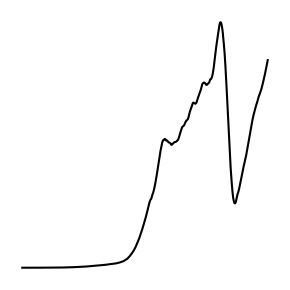

In [9]:
plt.figure(figsize= (3, 3))
plt.plot(x_data, data_shuffle[3089,:,0],  color='k', linewidth=1.5)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.tight_layout()


# Generación de Imagenes

In [ ]:
def images(x, data_shuffle, carpeta1, carpeta2):
    
    if not os.path.exists(carpeta1):
        os.makedirs(carpeta1)
        
    if not os.path.exists(carpeta2):
        os.makedirs(carpeta2)

    for i in range(data_shuffle.shape[0]):
        ruta_imagen1 = os.path.join(carpeta1, f"{i}.png") 

        plt.figure(figsize= (3, 3))
        plt.plot(x, data_shuffle[i,:,0],  color='k', linewidth=1.5)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(ruta_imagen1, bbox_inches='tight', pad_inches=0)  
        plt.close() 
        
      
    for j in range(data_shuffle.shape[0]):
        ruta_imagen2 = os.path.join(carpeta2, f"{j}.png") 
        plt.figure(figsize= (3, 3))
        plt.plot(x, data_shuffle[j,:,1],  color='k', linewidth=1.5 )
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(ruta_imagen2, bbox_inches='tight', pad_inches=0)  
        plt.close() 
        
carpeta1 = "Dataset/img/imagenes"
carpeta2 = "Dataset/img/imagenes_derivate"

images(x_data, data_shuffle, carpeta1,carpeta2 )

# Mapeo de los Targets

In [173]:
image_label_map = {}
for idx, label in enumerate(target_shuffle):
    image_label_map[idx] = label
image_label_map

{0: 2.08,
 1: 2.12,
 2: 1.94,
 3: 1.98,
 4: 2.07,
 5: 2.51,
 6: 2.62,
 7: 3.19,
 8: 2.244,
 9: 2.31,
 10: 2.26,
 11: 3.43,
 12: 2.59,
 13: 2.245,
 14: 2.21,
 15: 3.41,
 16: 3.36,
 17: 2.25,
 18: 1.99,
 19: 3.39,
 20: 2.08,
 21: 2.06,
 22: 2.06,
 23: 2.069,
 24: 3.25,
 25: 2.08,
 26: 2.49,
 27: 2.18,
 28: 1.99,
 29: 2.93,
 30: 2.13,
 31: 2.05,
 32: 2.52,
 33: 1.97,
 34: 3.06,
 35: 2.59,
 36: 2.15,
 37: 3.33,
 38: 2.032,
 39: 2.149,
 40: 2.2,
 41: 3.4,
 42: 2.24,
 43: 3.36,
 44: 2.17,
 45: 1.92,
 46: 3.24,
 47: 3.34,
 48: 3.38,
 49: 3.22,
 50: 3.0,
 51: 3.09,
 52: 5.208,
 53: 1.98,
 54: 2.13,
 55: 2.18,
 56: 3.3,
 57: 2.067,
 58: 1.97,
 59: 2.04,
 60: 1.96,
 61: 3.38,
 62: 3.36,
 63: 2.18,
 64: 3.37,
 65: 3.36,
 66: 3.22,
 67: 2.11,
 68: 3.36,
 69: 5.063,
 70: 2.02,
 71: 2.155,
 72: 2.125,
 73: 2.93,
 74: 2.029,
 75: 3.21,
 76: 2.31,
 77: 2.09,
 78: 3.32,
 79: 2.21,
 80: 3.42,
 81: 3.35,
 82: 2.59,
 83: 2.57,
 84: 3.376,
 85: 2.3,
 86: 3.42,
 87: 3.25,
 88: 2.029,
 89: 1.85,
 90: 2.72,
 

# DataLoader 

In [167]:
# Clase CustomimageDataset
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, root_dir_derivative, image_label_map, transform=None):
        #Inicializacion de variables
        self.root_dir = root_dir
        self.root_dir_derivative = root_dir_derivative
        self.image_label_map = image_label_map
        self.transform = transform

        self.image_files = [file for file in os.listdir(root_dir)]
        self.image_files.sort() 
        self.image_files_derivative = [f"{file.split('.')[0]}_derivada.png" for file in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        #Concatenando la dirección de la carpetas con el nombre de las imagenes
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        img_name_derivative = os.path.join(self.root_dir_derivative, self.image_files_derivative[idx]) 
        
        #Abre la imagen original cuya ruta en el sistema de archivos está especificada
        image = Image.open(img_name)  
        image_derivative = Image.open(img_name_derivative)
        
        #Transformaciones de la imagen abierta
        if self.transform:
            image = self.transform(image)
            image_derivative = self.transform(image_derivative)
            
        #Concatenación de las matrices de las imagenes en dos canales
        image_combined = torch.cat((image[0:1, :, :], image_derivative[0:1, :, :]), dim=0)

        label = self.image_label_map[int(self.image_files[idx].split('.')[0])]

        label = torch.tensor(label, dtype=torch.float)
        
        filename = int(self.image_files[idx].split('.')[0])

        return image_combined, label, filename

### Dataloader Discretizado 

In [168]:
# Se redimensiona la imagen de 270x270 a 64x64, ademas se Normaliza con una media de 0.5 y una desviacion estandar de 0.5
#Se discretiza, Convirtiendo todos los píxeles de la imagen que son mayores que 0.64 a 1.0 (float), y el resto a 0.0 (float).
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:2, :, :]), 
    transforms.Normalize((0.5, 0.5), (0.5, 0.5)),  
    transforms.Lambda(lambda x: (x > 0.64).float()) 
])
#Instanciacion de la clase custom
dataset = CustomImageDataset(
    root_dir='Dataset/img/imagenes',
    root_dir_derivative='Dataset/img/imagenes_derivate',
    image_label_map=image_label_map,
    transform=transform,
)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
indices = list(range(len(dataset)))

train_indices = indices[:train_size]
test_indices = indices[train_size:]

#dividiendo los datos en entrenamiento y prueba
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [169]:
# Se redimensiona la imagen de 270x270, ademas se Normaliza con una media de 0.5 y una desviacion estandar de 0.5
#Se discretiza, Convirtiendo todos los píxeles de la imagen que son menores que 0.64 a 1.0 (float), y el resto a 0.0 (float).
transform2 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:2, :, :]),  # Tomar solo los primeros dos canales
    transforms.Normalize((0.5, 0.5), (0.5, 0.5)),
    transforms.Lambda(lambda x: (x < 0.64).float())  
])

dataset2 = CustomImageDataset(
    root_dir='Dataset/img/imagenes',
    root_dir_derivative='Dataset/img/imagenes_derivate',
    image_label_map=image_label_map,
    transform= transform2,
)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
indices = list(range(len(dataset)))

train_indices = indices[:train_size]
test_indices = indices[train_size:]
#dividiendo los datos en entrenamiento y prueba
train_dataset2 = torch.utils.data.Subset(dataset2, train_indices)
test_dataset2 = torch.utils.data.Subset(dataset2, test_indices)
#Creando el data loader
train_loader2 = DataLoader(train_dataset2, batch_size= 500, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=500, shuffle=False)

## Visualización 


Forma del tensor de imagen: torch.Size([2, 64, 64])
Nombre de la imagen: 988.png 


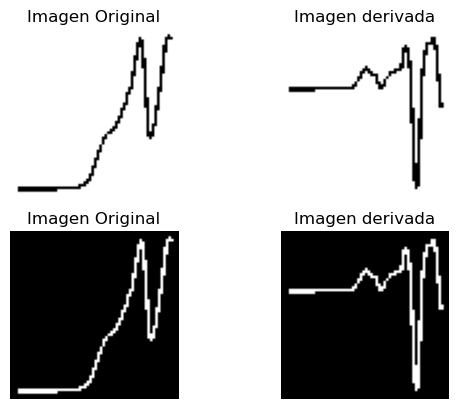

In [171]:
magen, _ , img = test_dataset.__getitem__(605)
magen2, _ , img2 = test_dataset2.__getitem__(605)

print("Forma del tensor de imagen:", magen.shape)

magen_numpy = magen.numpy()
magen2_numpy = magen2.numpy()
print(f'Nombre de la imagen: {img2}.png ')
fig, axs = plt.subplots(2, 2)
axs[0][0].imshow(magen_numpy[0, :, :], cmap='gray')  
axs[0][0].set_title("Imagen Original")
axs[0][0].axis('off')

axs[0][1].imshow(magen_numpy[1, :, :], cmap='gray')  
axs[0][1].set_title("Imagen derivada")
axs[0][1].axis('off')

axs[1][0].imshow(magen2_numpy[0, :, :], cmap='gray')  
axs[1][0].set_title("Imagen Original")
axs[1][0].axis('off')

axs[1][1].imshow(magen2_numpy[1, :, :], cmap='gray')  
axs[1][1].set_title("Imagen derivada")
axs[1][1].axis('off')

plt.show()


# CNN y Entrenamiento

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim



#red neuronal convolucional CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #Se ingresa dos canales
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1) #imagen de salida 64x64, 
        self.relu1 = nn.ReLU() #funcion de activacion 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #imagen de salida 32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) #imagen de salida 32x32
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #Imagen de salida 16x16
        #Capa completamente conectada (fully connected layer)
        self.fc1 = nn.Linear(64 * 16 * 16, 128) 
        self.relu3 = nn.ReLU()
        #Capa completamente conectada (fully connected layer)
        self.fc2 = nn.Linear(128, 1) #una salida
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

#Entrenamiento del CNN 
def train(modelo, train_loader, criterion, optimizer, epochs, lr):
        
        optimizer = optimizer(modelo.parameters(), lr=lr)
        losses = []
        for epoch in range(epochs):
            running_loss = 0.0
            for i, (inputs, labels, _ ) in enumerate(train_loader, 0):
                # Mover los datos a CUDA
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels.view(-1, 1).float())

                # Backward pass y optimización
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            losses.append(epoch_loss)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss}')
        return losses


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

Epocas = 50
lr = 0.01
#Instanciar la red
model = CNN()
model.to(device) #mover el modelo a cuda
#Entrenamiento del modelo
loss = train(model, train_loader2, nn.MSELoss(), optim.SGD, epochs= Epocas, lr= lr)

## Prueba con el Test 

Predicción de Bandgap para el 479: 1.8856645822525024
BandGap original:  2.22


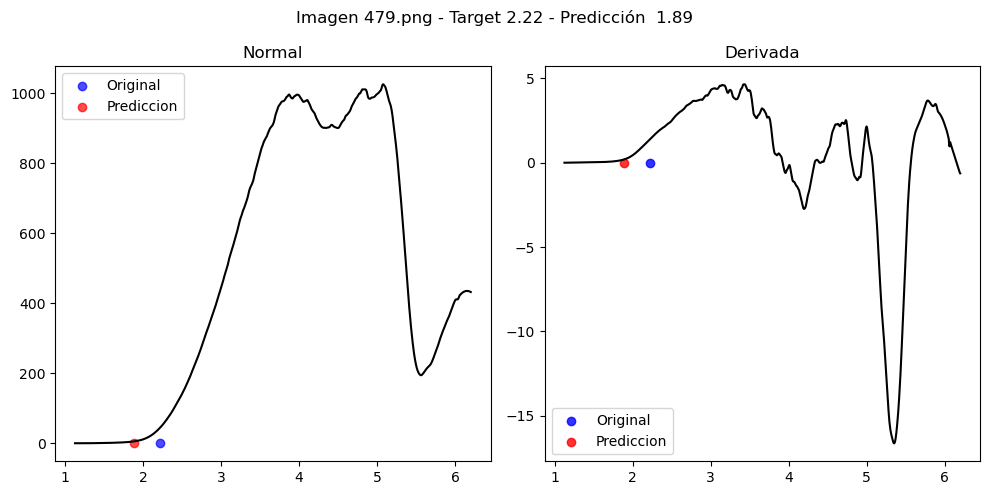

In [192]:
image, label, di = test_dataset2.__getitem__(40)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)

model = model.to(device)
model.eval()  
with torch.no_grad():
    outputs = model(image)

predicted_bandgap = outputs.mean().item()
print(f"Predicción de Bandgap para el {di}:", predicted_bandgap)
print('BandGap original: ', target_shuffle[di])

ID = di
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(x_data, data_shuffle[ID, :, 0], color='k')
axs[0].scatter(target_shuffle[ID], 0, color='blue', label=f'Original', alpha=0.7)
axs[0].scatter(predicted_bandgap, 0, color='red',  label=f'Prediccion', alpha=0.7)
axs[0].set_title('Normal')
axs[0].legend()


axs[1].plot(x_data, data_shuffle[ID, :, 1], color='k')
axs[1].scatter(target_shuffle[ID], 0, color='blue', label=f'Original', alpha=0.8)
axs[1].scatter(predicted_bandgap, 0, color='red', label=f'Prediccion', alpha=0.8)
axs[1].set_title('Derivada')
axs[1].legend()

fig.suptitle(f'Imagen {di}.png - Target {target_shuffle[ID]} - Predicción  {predicted_bandgap:.2f}')
plt.tight_layout()
plt.show()

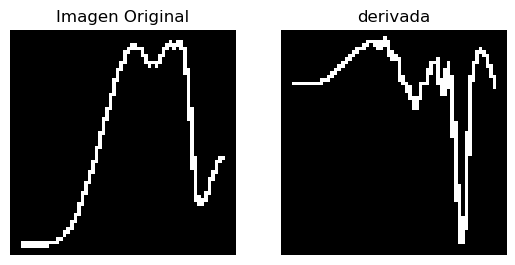

In [181]:
image_cpu = image.cpu()  
photo = image_cpu.numpy()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(photo[0, :, :], cmap='gray')  
axs[0].set_title("Imagen Original")
axs[0].axis('off')

axs[1].imshow(photo[1, :, :], cmap='gray')  
axs[1].set_title("derivada")
axs[1].axis('off')

plt.show()


# Metricas

In [141]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def compute_regression_metrics(model, data_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs = inputs.to(device)  # Mover datos a la GPU
            outputs = model(inputs)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(outputs.cpu().numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calcular las métricas de regresión
    mae = mean_absolute_error(true_labels, predicted_labels)
    mse = mean_squared_error(true_labels, predicted_labels)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_labels, predicted_labels)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R^2 Score:", r2)

    return mae, mse, rmse, r2


In [193]:
mae, mse, rmse, r2 = compute_regression_metrics(model, test_loader2)

Mean Absolute Error (MAE): 0.44000658
Mean Squared Error (MSE): 0.30142394
Root Mean Squared Error (RMSE): 0.5490209
R^2 Score: 0.2972063292924805
